# Noise Reduction Using PCA and Autoencoders

By Amirhossein Abolhasani

## Importing Dependencies

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Scikit learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.util import random_noise

# Pytorch
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

In [2]:
r_seed = 42

np.random.seed(r_seed)

## Loading FashionMNIST Dataset

In [3]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.56MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
labels_map = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot'
    }

### A Look at the Dataset

Text(0.5, 1.02, 'FashionMNIST Dataset')

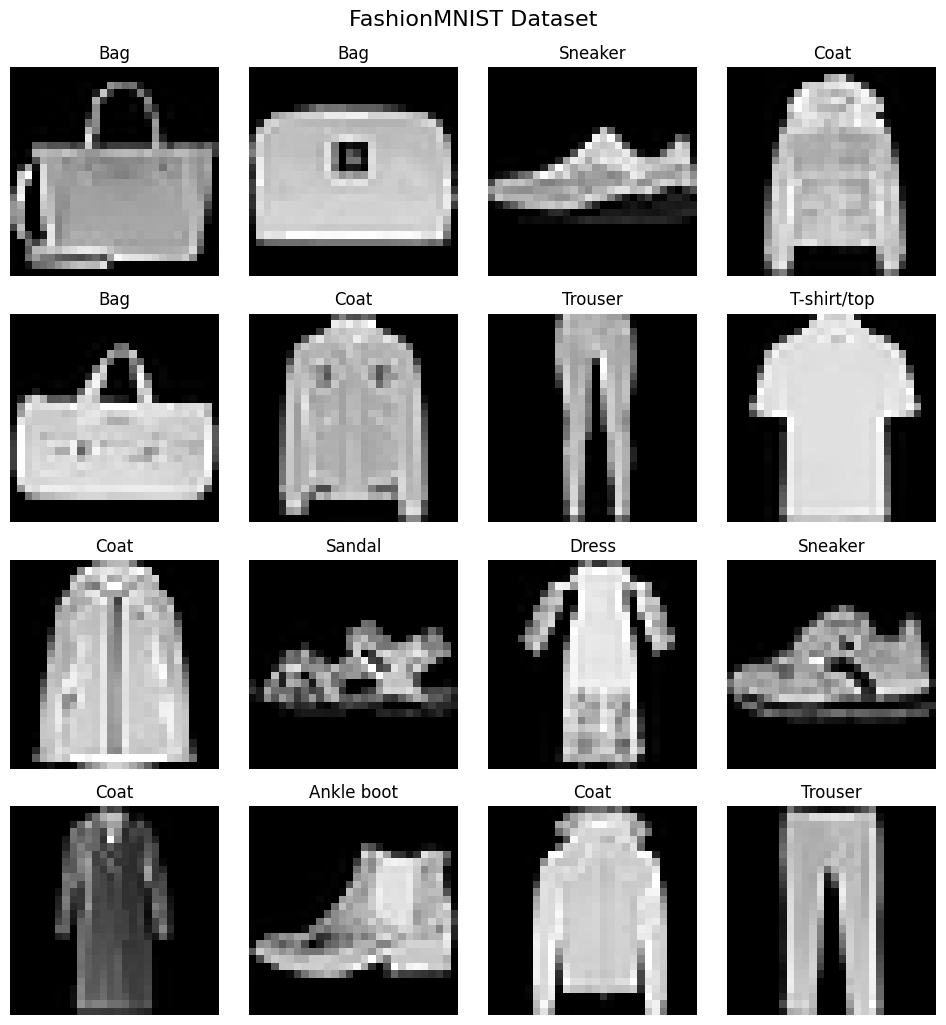

In [5]:
grid_size = (4, 4)

fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)

indices = np.random.choice(
    len(train_dataset),
    size=grid_size[0] * grid_size[1],
    replace=False
)

idx = 0
for i in range(grid_size[0]):
  for j in range(grid_size[1]):
    axes[i, j].imshow(train_dataset[indices[idx]][0].squeeze(), cmap='gray')

    axes[i, j].axis('off')
    axes[i, j].set_title(labels_map[train_dataset[indices[idx]][1]])

    idx += 1

plt.tight_layout()
plt.suptitle('FashionMNIST Dataset', y=1.02, size=16 )

In [6]:
X_train = train_dataset.data.numpy().astype('float32') / 255
X_test = test_dataset.data.numpy().astype('float32') / 255

y_train = train_dataset.targets.numpy()
y_test = test_dataset.targets.numpy()

In [7]:
X_train.shape

(60000, 28, 28)

In [8]:
X_test.shape

(10000, 28, 28)

## Adding Noise

In [9]:
X_train_noisy = random_noise(
    X_train,
    mode='gaussian',
    var=0.1,
    clip=True
)

X_test_noisy = random_noise(
    X_test,
    mode='gaussian',
    var=0.1,
    clip=True
)

Text(0.5, 1.02, 'FashionMNIST Noisy Dataset')

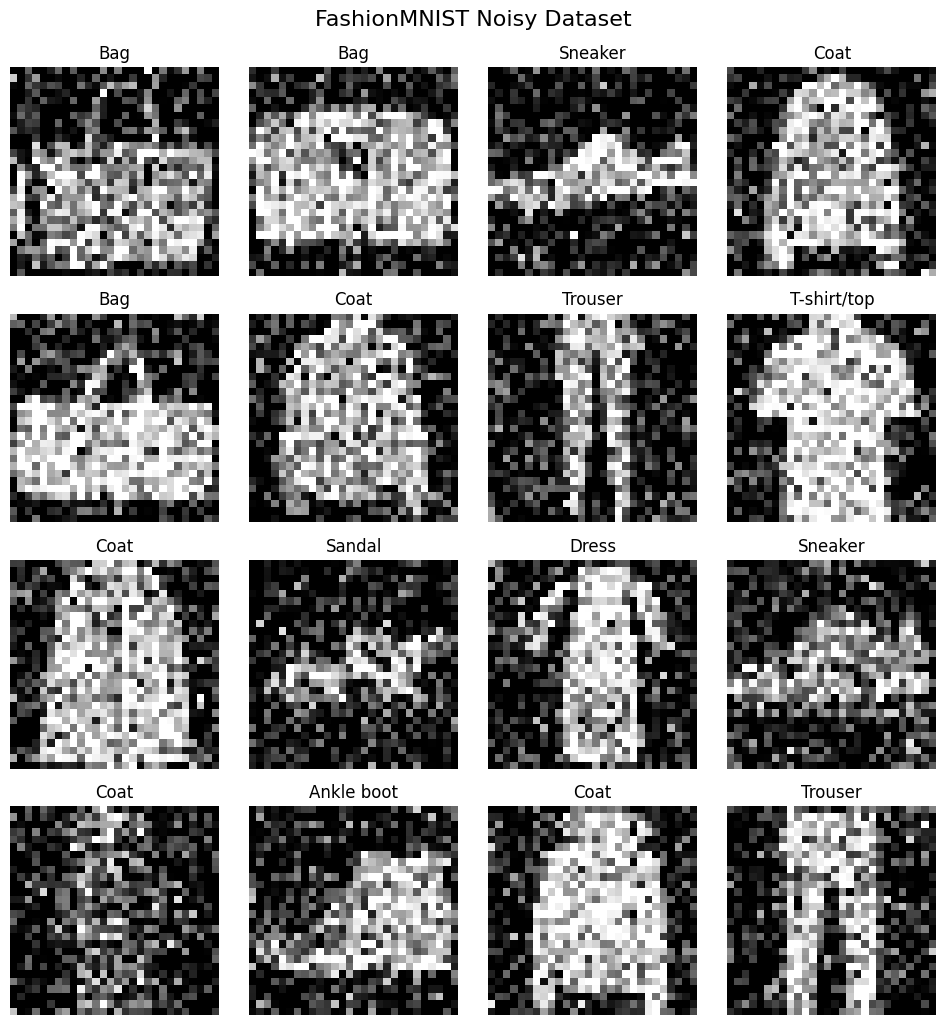

In [10]:
grid_size = (4, 4)

fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)

idx = 0
for i in range(grid_size[0]):
  for j in range(grid_size[1]):
    axes[i, j].imshow(X_train_noisy[indices[idx]].squeeze(), cmap='gray')

    axes[i, j].axis('off')
    axes[i, j].set_title(labels_map[train_dataset[indices[idx]][1]])

    idx += 1

plt.tight_layout()
plt.suptitle('FashionMNIST Noisy Dataset', y=1.02, size=16 )

## Noise Reduction Using PCA

### Dataset Flattening

In [11]:
X_train_noisy_flatten = X_train_noisy.reshape(-1, 28 * 28)
X_test_noisy_flatten = X_test_noisy.reshape(-1, 28 * 28)

X_train_flatten = X_train.reshape(-1, 28 * 28)
X_test_flatten = X_test.reshape(-1, 28 * 28)

### Finding the right amount of components
Based on MSE, we try to see what `k` is the best number for choosing `k` components

In [12]:
pca = PCA(784).fit(X_train_noisy_flatten)

In [13]:
history = dict()

In [14]:
for k in range(50, 610, 10):
  transformed = np.dot(X_test_noisy_flatten - pca.mean_, pca.components_[:k].T)
  reconstructed = np.dot(transformed, pca.components_[:k]) + pca.mean_


  mse = np.mean((X_test_flatten - reconstructed)**2)
  history[k] = mse

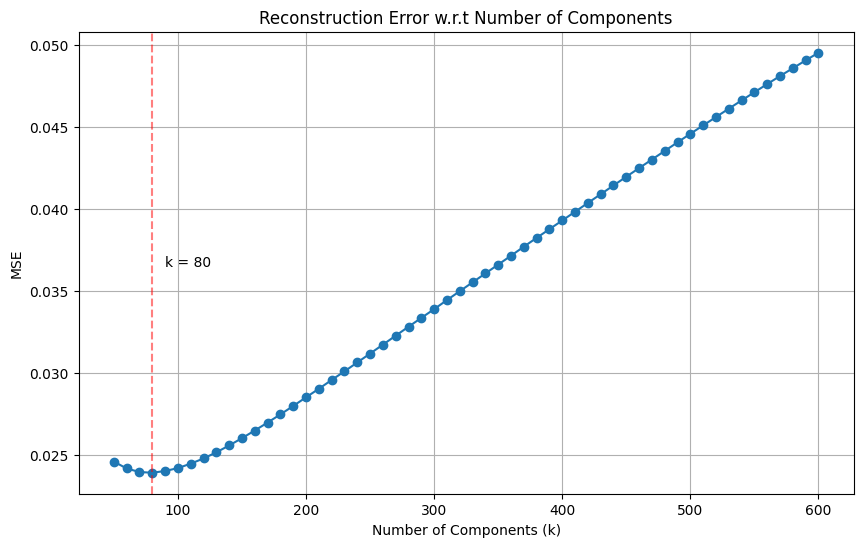

In [15]:
k_values = np.array(list(history.keys()))
mse_values = np.array(list(history.values()))

best_k = k_values[np.argmin(mse_values)]

plt.figure(figsize=(10, 6))
plt.plot(k_values, mse_values, marker='o')

plt.axvline(x=best_k, color='r', linestyle='--', alpha=0.5)

plt.text(best_k + 10, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0])*0.5,
             f'k = {best_k}',
             verticalalignment='center')

plt.xlabel('Number of Components (k)')
plt.ylabel('MSE')
plt.title('Reconstruction Error w.r.t Number of Components')
plt.grid(True)
plt.show()

### Image Reconstruction

In [16]:
transformed = np.dot(X_test_noisy_flatten - pca.mean_, pca.components_[:best_k].T)
X_test_denoised_pca = (np.dot(transformed, pca.components_[:best_k]) + pca.mean_).reshape(-1, 28, 28)

## Noise Reduction Using Autoencoders

### Autoencoder Class Definition

In [17]:
class Autoencoder(nn.Module):
  def __init__(self, latent_dim=128):
    super(Autoencoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, latent_dim),
        nn.ReLU()
    )

    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 784),
        nn.Sigmoid()
    )


  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

### Training Process

#### Setting Up Environment

In [31]:
# Changeable
config = {
    'batch size': 128,
    'epochs': 25,
    'lr': 1e-3,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

In [32]:
train_hist = {
    'train loss': [],
    'test loss': [],
}

In [33]:
autoencoder = Autoencoder(latent_dim=128).to(config['device'])

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=config['lr'])

In [34]:
Y_train_flatten_tensor = torch.FloatTensor(X_train_flatten).to(config['device']) # target of autoencoder train mode
X_train_noisy_flatten_tensor = torch.FloatTensor(X_train_noisy_flatten).to(config['device']) # input of autoencoder train mode

Y_test_flatten_tensor = torch.FloatTensor(X_test_flatten).to(config['device']) # target of autoencoder eval mode
X_test_noisy_flatten_tensor = torch.FloatTensor(X_test_noisy_flatten).to(config['device']) # input of autoencoder eval mode

#### Training Loop

In [35]:
for epoch in range(config['epochs']):
  print(f"___________ Epoch: {epoch} ___________")
  train_loss = []
  test_loss = []

  autoencoder.train()
  for idx in tqdm(range(0, X_train_noisy_flatten_tensor.shape[0], config['batch size'])):
    X_batch = X_train_noisy_flatten_tensor[idx:idx + config['batch size']]
    Y_batch = Y_train_flatten_tensor[idx:idx + config['batch size']]

    optimizer.zero_grad()

    outputs = autoencoder(X_batch)
    loss = criterion(outputs, Y_batch)

    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

  autoencoder.eval()
  with torch.no_grad():
    test_outputs = autoencoder(X_test_noisy_flatten_tensor)
    t_loss = criterion(test_outputs, Y_test_flatten_tensor).item()

    test_loss.append(t_loss)

  train_hist['train loss'].append(np.mean(train_loss))
  train_hist['test loss'].append(np.mean(test_loss))

___________ Epoch: 0 ___________


100%|██████████| 469/469 [00:01<00:00, 463.73it/s]


___________ Epoch: 1 ___________


100%|██████████| 469/469 [00:00<00:00, 472.31it/s]


___________ Epoch: 2 ___________


100%|██████████| 469/469 [00:01<00:00, 465.76it/s]


___________ Epoch: 3 ___________


100%|██████████| 469/469 [00:01<00:00, 467.80it/s]


___________ Epoch: 4 ___________


100%|██████████| 469/469 [00:00<00:00, 472.01it/s]


___________ Epoch: 5 ___________


100%|██████████| 469/469 [00:01<00:00, 468.42it/s]


___________ Epoch: 6 ___________


100%|██████████| 469/469 [00:00<00:00, 476.29it/s]


___________ Epoch: 7 ___________


100%|██████████| 469/469 [00:00<00:00, 471.86it/s]


___________ Epoch: 8 ___________


100%|██████████| 469/469 [00:00<00:00, 475.30it/s]


___________ Epoch: 9 ___________


100%|██████████| 469/469 [00:01<00:00, 389.14it/s]


___________ Epoch: 10 ___________


100%|██████████| 469/469 [00:01<00:00, 359.27it/s]


___________ Epoch: 11 ___________


100%|██████████| 469/469 [00:01<00:00, 468.63it/s]


___________ Epoch: 12 ___________


100%|██████████| 469/469 [00:00<00:00, 470.40it/s]


___________ Epoch: 13 ___________


100%|██████████| 469/469 [00:00<00:00, 470.91it/s]


___________ Epoch: 14 ___________


100%|██████████| 469/469 [00:00<00:00, 470.87it/s]


___________ Epoch: 15 ___________


100%|██████████| 469/469 [00:00<00:00, 474.43it/s]


___________ Epoch: 16 ___________


100%|██████████| 469/469 [00:01<00:00, 467.64it/s]


___________ Epoch: 17 ___________


100%|██████████| 469/469 [00:00<00:00, 476.03it/s]


___________ Epoch: 18 ___________


100%|██████████| 469/469 [00:01<00:00, 467.00it/s]


___________ Epoch: 19 ___________


100%|██████████| 469/469 [00:00<00:00, 470.93it/s]


___________ Epoch: 20 ___________


100%|██████████| 469/469 [00:01<00:00, 430.68it/s]


___________ Epoch: 21 ___________


100%|██████████| 469/469 [00:01<00:00, 392.22it/s]


___________ Epoch: 22 ___________


100%|██████████| 469/469 [00:01<00:00, 390.42it/s]


___________ Epoch: 23 ___________


100%|██████████| 469/469 [00:00<00:00, 474.21it/s]


___________ Epoch: 24 ___________


100%|██████████| 469/469 [00:01<00:00, 468.59it/s]


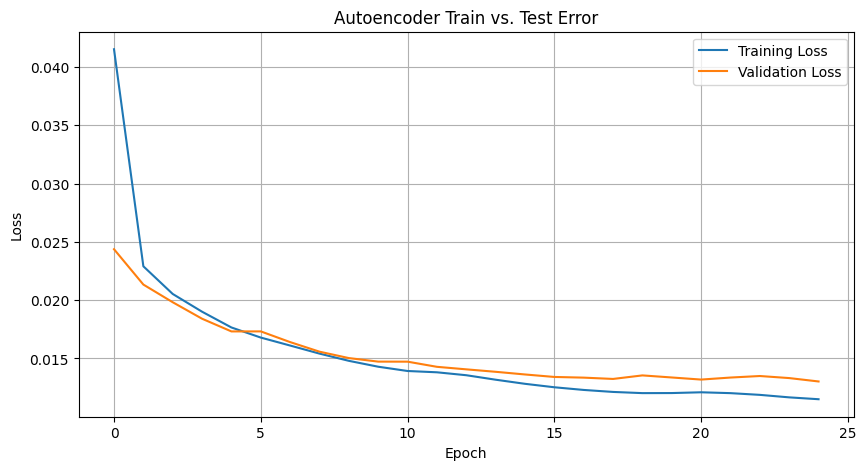

In [36]:
plt.figure(figsize=(10, 5))

plt.plot(np.arange(config['epochs']), train_hist['train loss'],label='Training Loss')
plt.plot(np.arange(config['epochs']), train_hist['test loss'],label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Train vs. Test Error')

plt.legend()
plt.grid(True)
plt.show()

### Image Denoising


In [37]:
autoencoder.eval()

with torch.no_grad():
  X_test_denoised_ae = autoencoder(X_test_noisy_flatten_tensor)
  X_test_denoised_ae = X_test_denoised_ae.cpu().numpy().reshape(-1, 28, 28)

## Comparing Results

### MSE Comparison

In [51]:
# Evaluating MSE for PCA
error  = (X_test_denoised_pca.reshape(-1, 28*28) - X_test_flatten)
MSE_pca = np.mean(error ** 2)

In [53]:
# Evaluating MSE for Autoencoder
error  = (X_test_denoised_ae.reshape(-1, 28*28) - X_test_flatten)
MSE_ae = np.mean(error ** 2)

In [61]:
print(f"MSE for PCA approach on test data: {np.round(MSE_pca, 4)}")
print(f"MSE for autoencoder approach on test data: {np.round(MSE_ae.astype('float64'), 4)}")

MSE for PCA approach on test data: 0.0239
MSE for autoencoder approach on test data: 0.013


### Image Construction Comparison

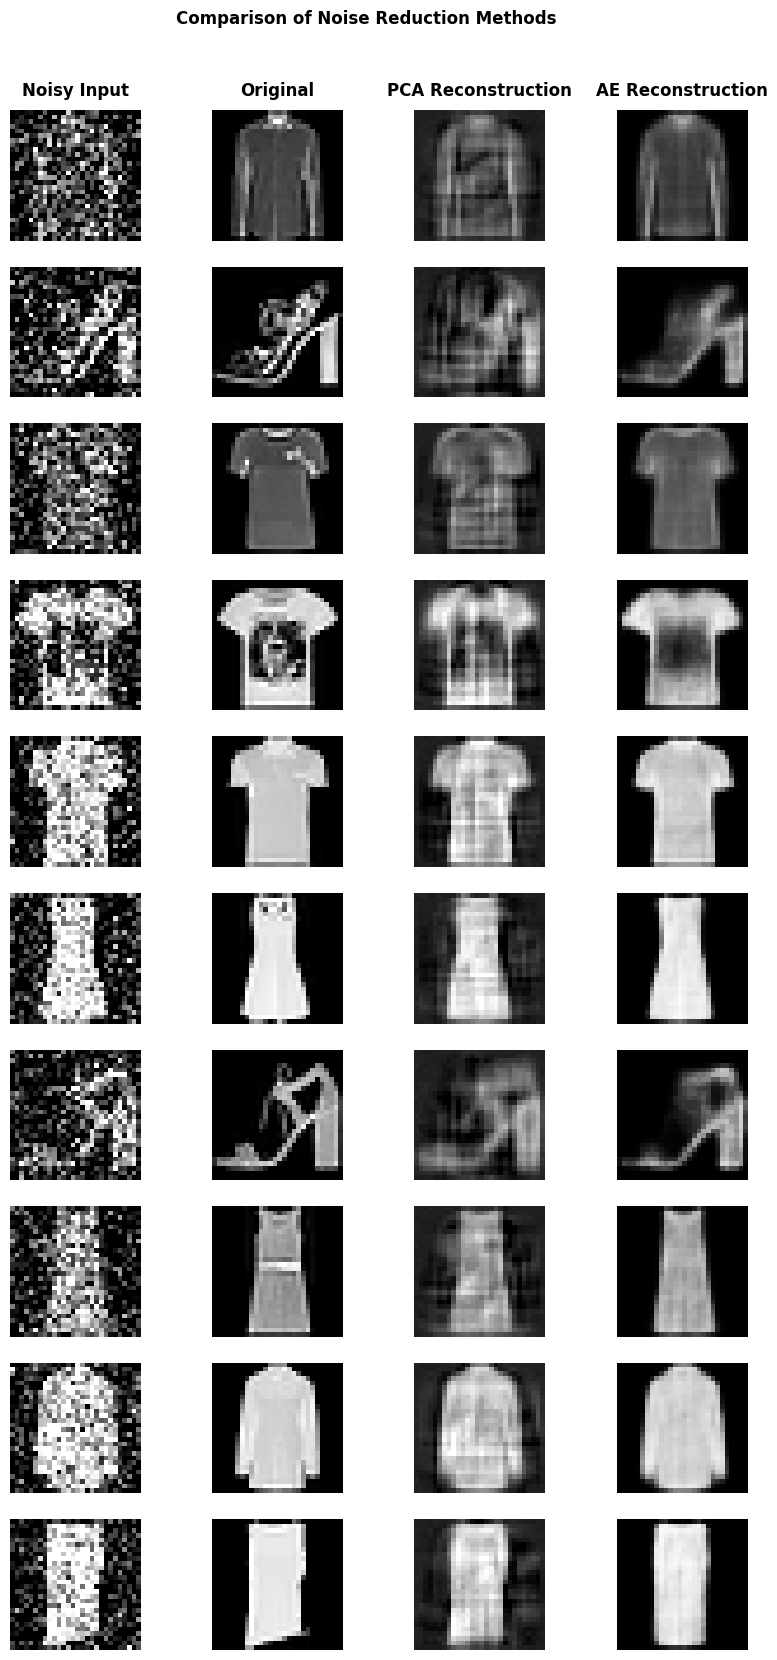

In [50]:
sample_size = 10 # You can change this

indices = np.random.choice(range(0, len(X_test_noisy)), size=sample_size, replace=False )

pca_images = X_test_denoised_pca[indices]
ae_images = X_test_denoised_ae[indices]
original_images = X_test[indices]
noisy_images = X_test_noisy[indices]
targets = y_test[indices]


fig, axes = plt.subplots(sample_size, 4, figsize=(10, 2 * sample_size))

cols= ['Noisy Input', 'Original', 'PCA Reconstruction', 'AE Reconstruction']
for ax, col in zip(axes[0], cols):
  ax.set_title(col, size=12, pad=10, fontweight='bold')

for i in range(sample_size):
  axes[i, 0].imshow(noisy_images[i], cmap='gray', vmin=0, vmax=1)
  axes[i, 1].imshow(original_images[i], cmap='gray', vmin=0, vmax=1)
  axes[i, 2].imshow(pca_images[i], cmap='gray', vmin=0, vmax=1)
  axes[i, 3].imshow(ae_images[i], cmap='gray', vmin=0, vmax=1)

  axes[i, 0].axis('off')
  axes[i, 1].axis('off')
  axes[i, 2].axis('off')
  axes[i, 3].axis('off')

plt.subplots_adjust(hspace=0.2)
plt.suptitle('Comparison of Noise Reduction Methods',y=0.93, size=12, weight='bold')

plt.show()